# Monitor: 

- Loss
- pearson correlation
- prediction R2 (=prediction performace)

In [23]:
import pandas as pd
import numpy as np
import pickle 
import torch
from scripts.visualisation import plot_cpg_reconstruction, plot_activations_latSpace
from data.prepareData import prepareDataLoader_fromPkl
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.python.summary.summary_iterator import summary_iterator

# Load Data

In [24]:
PATH_data = "data"
PATH_results = "logs"


with open(os.path.join(PATH_data, "chr22_overlap_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

# Load Model

In [5]:
name = f"optLatSize/latSize_10"
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

# Run on test data
with torch.no_grad():
    recon = model(test_tensor).detach().numpy()
    latSpace = model.generate_embedding(test_tensor)

# Monitor (validation) loss

last recorded loss value

In [24]:
def getValLoss(name):
    for file in os.listdir(f"logs/{name}"):
        if file.startswith("events"):
            val_loss = []
            for summary in summary_iterator(f"logs/{name}/{file}"):
                if summary.summary.value:
                    if summary.summary.value[0].tag == "Val - Loss":
                        val_loss.append(summary.summary.value[0].simple_value)
    return val_loss[-10:]

In [25]:
getValLoss(name)

[657.7948608398438,
 646.923095703125,
 763.709716796875,
 644.9085083007812,
 663.1226806640625,
 747.9622802734375,
 681.7310791015625,
 678.5786743164062,
 783.499755859375,
 813.3938598632812]

# Monitor pearson correlation of reconstruction

In [29]:
def getPearsonR(orig, recon):
    from scipy.stats import pearsonr
    pearson = []
    for i in range(recon.shape[1]):
        pearson.append(pearsonr(orig.detach().numpy()[:,i], recon[:,i])[0])

    return pearson

In [32]:
pearsonCorr = getPearsonR(test_tensor, recon)

<AxesSubplot:ylabel='Frequency'>

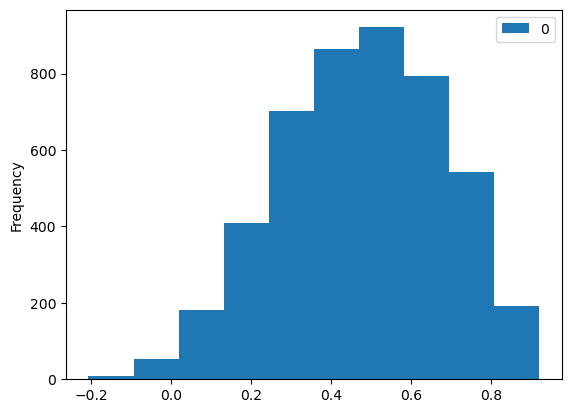

In [33]:
pd.DataFrame(pearsonCorr, index=test_dataset["beta"].columns).plot.hist()

# Monitor prediction performance

In [37]:
def getRegression(name, latSpace, test_data):
    regrPath = f"logs/{name}/regression"
    regr_model = pickle.load(open(f"{regrPath}/RFregressor.sav", 'rb'))

    # Impute missing values target values with mean (quick & dirty)
    y_test_filled = test_data["pheno"]["Age"].fillna(value=test_data["pheno"]["Age"].mean())

    y_pred = regr_model.predict(latSpace)
    r2 = regr_model.score(latSpace, y_test_filled)
    print(r2)

    return y_pred, r2

In [38]:
y_pred, r2 = getRegression(name, latSpace, test_dataset)

0.5892357787539697


Text(0, 0.5, 'Predicted Age')

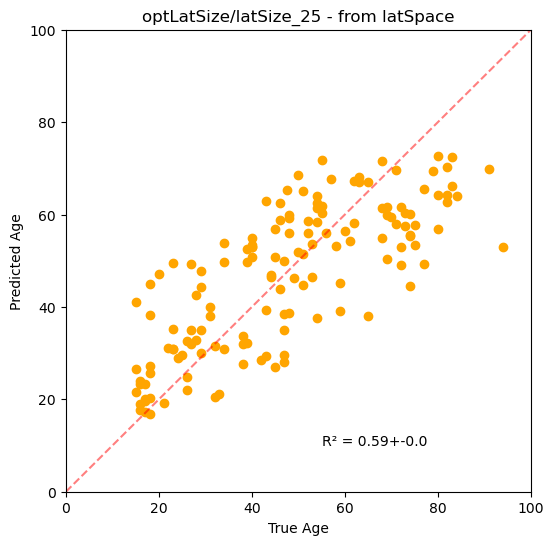

In [39]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_test_filled, y_pred, color="orange")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red", linestyle="dashed", alpha=0.5)
ax.text(55, 10, f"R² = {round(r2.mean(),2)}+-{round(r2.std(),2)}")
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_title(f"{name} - from latSpace")
ax.set_xlabel("True Age")
ax.set_ylabel("Predicted Age")

# All in one pipeline

In [25]:
def getValLoss(name):
    for file in os.listdir(f"logs/{name}"):
        if file.startswith("events"):
            val_loss = []
            for summary in summary_iterator(f"logs/{name}/{file}"):
                if summary.summary.value:
                    if summary.summary.value[0].tag == "Val - Loss":
                        val_loss.append(summary.summary.value[0].simple_value)
    return val_loss[-10:]


def getPearsonR(orig, recon):
    from scipy.stats import pearsonr
    pearson = []
    for i in range(recon.shape[1]):
        pearson.append(pearsonr(orig.detach().numpy()[:,i], recon[:,i])[0])
    return pearson


def getRegression(name, latSpace, test_data):
    regrPath = f"logs/{name}/regression"
    regr_model = pickle.load(open(f"{regrPath}/RFregressor.sav", 'rb'))

    # Impute missing values target values with mean (quick & dirty)
    y_test_filled = test_data["pheno"]["Age"].fillna(value=test_data["pheno"]["Age"].mean())

    y_pred = regr_model.predict(latSpace)
    r2 = regr_model.score(latSpace, y_test_filled)
    print(r2)
    return r2 #y_pred
    

In [26]:
PATH_data = "data"
PATH_results = "logs"

with open(os.path.join(PATH_data, "chr22_overlap_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

In [32]:
names = ["optLatSize/latSize_3", 
        "optLatSize/latSize_5", 
         "optLatSize/latSize_7", 
         "optLatSize/latSize_10", 
         "optLatSize/latSize_25", 
         "optLatSize/latSize_50",
         "optLatSize/latSize_100", 
         "optLatSize/latSize_200"] 
# names = ["optLatSize_noDropOut/latSize_5", 
#          "optLatSize_noDropOut/latSize_7", 
#          "optLatSize_noDropOut/latSize_10", 
#          "optLatSize_noDropOut/latSize_25", 
#          "optLatSize_noDropOut/latSize_50", 
#          "optLatSize_noDropOut/latSize_100",
#          "optLatSize_noDropOut/latSize_200"] 
         
names_short = [ele.split("/")[1] for ele in names]

df_loss = pd.DataFrame()
df_pearson = pd.DataFrame()
lst_r2 = []
for name in names:
    model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

    # Get recon and latent space (from test data)
    with torch.no_grad():
        recon = model(test_tensor).detach().numpy()
        latSpace = model.generate_embedding(test_tensor)

    # Get Loss
    df_loss[name] = getValLoss(name)
    # Get Pearson
    df_pearson[name] = getPearsonR(orig=test_tensor, recon=recon)
    # Get supervised prediction (regression)
    lst_r2.append(getRegression(name, latSpace, test_dataset))

df_r2 = pd.DataFrame(lst_r2, index=names).T

0.6582370226152352
0.7180384712478611
0.6913185752930453
0.7253451165546119
0.7464558604816852
0.7550313961295498
0.7606100671757814
0.7577235778395257


(500.0, 700.0)

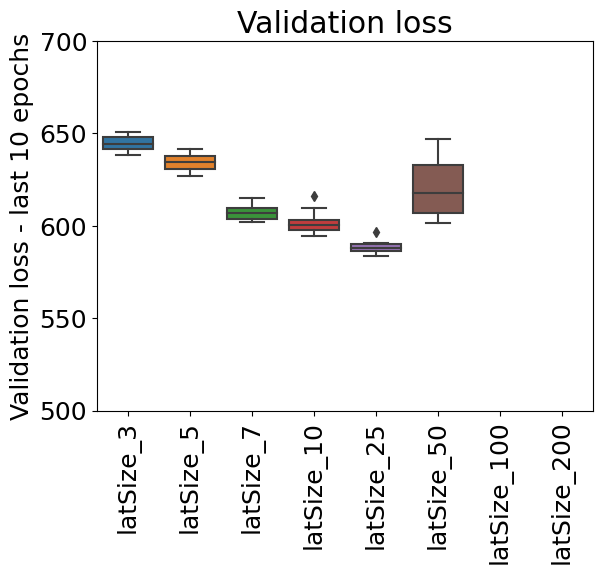

In [42]:
fig, ax = plt.subplots()
sns.boxplot(data=df_loss, ax=ax)
ax.set_xticklabels(names_short, rotation=90)
ax.set_ylabel("Validation loss - last 10 epochs")
ax.set_title("Validation loss")
ax.set_ylim(500,700)

Text(0.5, 1.0, 'Reconstruction accuracy - Pearson R')

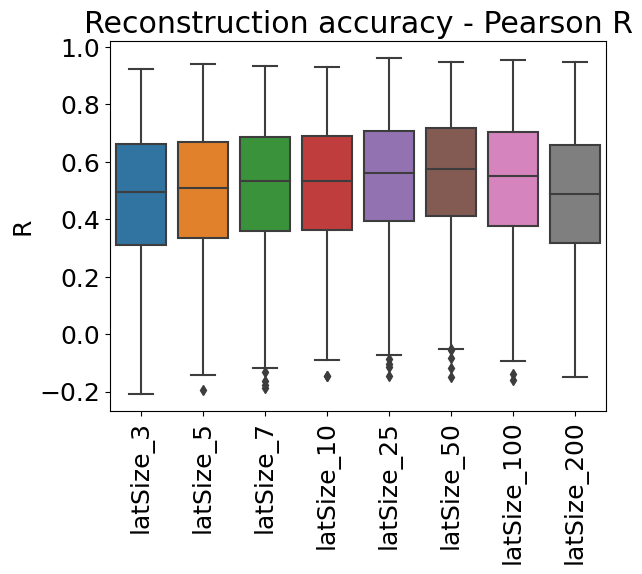

In [39]:
fig, ax = plt.subplots()
sns.boxplot(data=df_pearson)
ax.set_xticklabels(names_short, rotation=90)
ax.set_ylabel("R")
ax.set_title("Reconstruction accuracy - Pearson R")

Text(0.5, 1.0, 'RandomForestRegressor: Age prediction - R2 score')

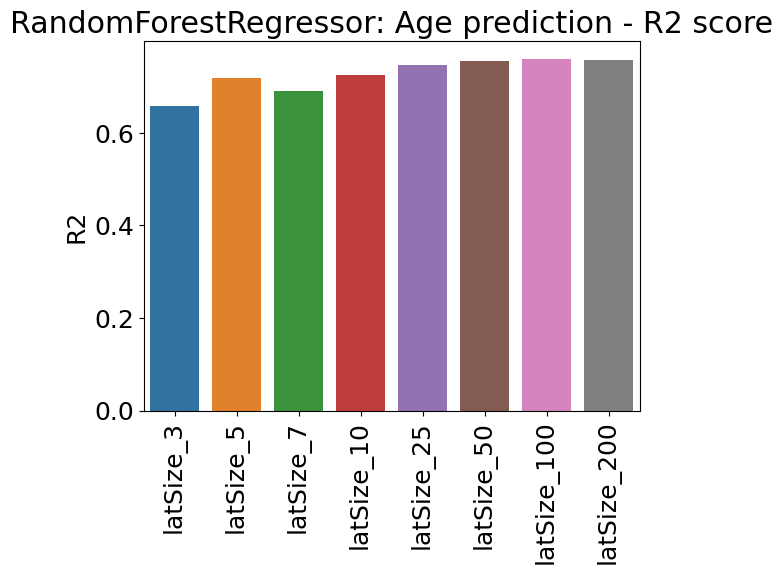

In [40]:
fig, ax = plt.subplots()
sns.barplot(data=df_r2, ax=ax)
ax.set_xticklabels(names_short, rotation=90)
ax.set_ylabel("R2")
ax.set_title("RandomForestRegressor: Age prediction - R2 score")

### Additional

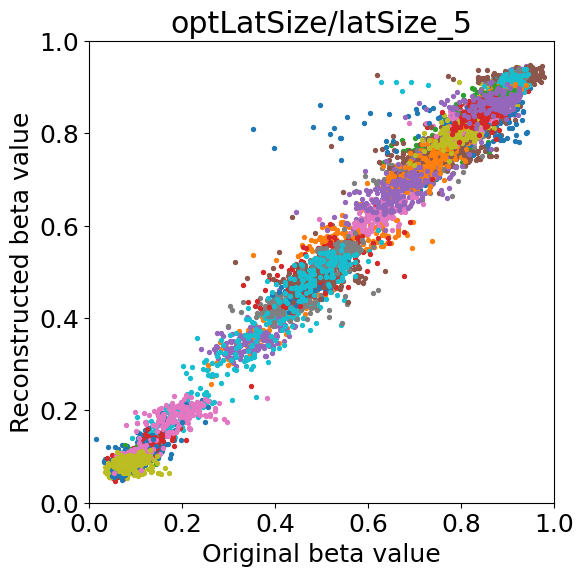

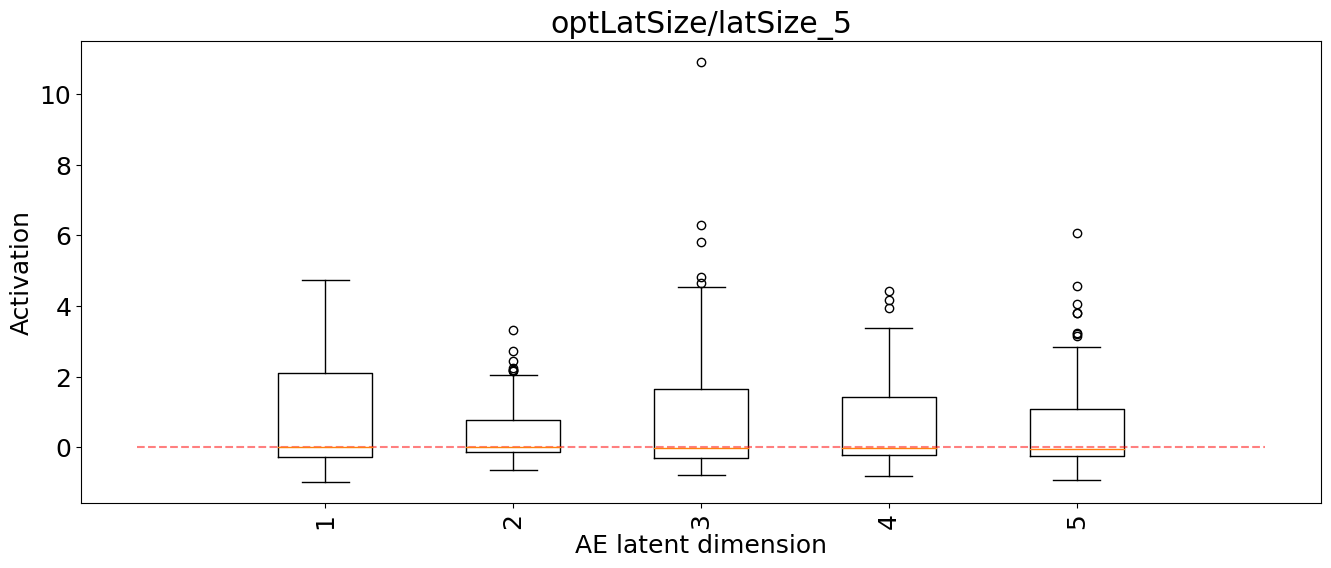

In [36]:
name2 = "optLatSize/latSize_5"
model2 = torch.load(f"logs/{name2}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

plot_cpg_reconstruction(model2, test_tensor, title=name2)
plot_activations_latSpace(model2, test_tensor, title=name2)